In [1]:
import warnings
warnings.simplefilter(action='ignore',)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Function
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from tqdm.auto import tqdm

import qiskit
from qiskit import Aer, QuantumCircuit, transpile, assemble
backend = Aer.get_backend("statevector_simulator")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

GeForce GTX 1080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [2]:
# 用 GPU建 quantum circuit很慢
device = torch.device('cpu')

NUM_EPOCHS = 40
EARLY_STOP = 4
NUM_CLASS = 10
BATCH_SIZE = 8
LEARN_RATE = 0.001

In [3]:
n_samples = 640

train_dataset = datasets.MNIST(root='../../data/', train=True, download=True,
                               transform=transforms.Compose([transforms.ToTensor()]))

train_dataset.data = train_dataset.data[:n_samples]
train_dataset.targets = train_dataset.targets[:n_samples]

train, valid = random_split(train_dataset,[512,128])

train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=BATCH_SIZE, shuffle=True)

In [4]:
n_samples = 128

test_dataset = datasets.MNIST(root='../../data/', train=False, download=True,
                              transform=transforms.Compose([transforms.ToTensor()]))

test_dataset.data = test_dataset.data[:n_samples]
test_dataset.targets = test_dataset.targets[:n_samples]

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [5]:
class QNN_circuit:
    
    def __init__(self, n_qubits, backend, shots):
        self._circuit = QuantumCircuit(n_qubits)
        self.theta = qiskit.circuit.Parameter('θ')
        
        self._circuit.h(range(n_qubits))
        self._circuit.barrier()
        self._circuit.ry(self.theta, range(n_qubits))     
        self._circuit.measure_all()
        
        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        t_qc = transpile(self._circuit, self.backend)
        qobj = assemble(t_qc, shots=self.shots, parameter_binds=[{self.theta: i} for i in thetas])
        
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
        
        probabilities = counts / self.shots
        expectation = np.sum(states * probabilities) 
        
        return np.array([expectation])

Expected value for rotation pi 552.3828125


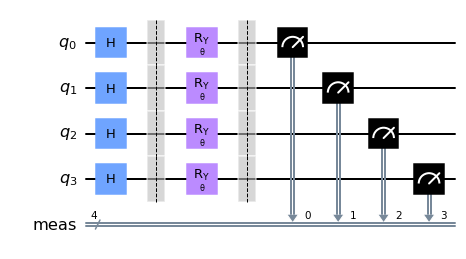

In [6]:
qc_display = QNN_circuit(4, backend, 128)
print('Expected value for rotation pi {}'.format(qc_display.run([np.pi])[0]))
qc_display._circuit.draw(output="mpl")

In [7]:
class HybridFunction(Function):

    def forward(ctx, inputs, quantum_circuit, shift):
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = []
        for input in inputs: expectation_z.append(ctx.quantum_circuit.run(input.tolist()))
        result = torch.tensor(expectation_z).to(device)
        
        ctx.save_for_backward(inputs, result)
        return result

    def backward(ctx, grad_output):
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]).to(device) - torch.tensor([expectation_left]).to(device)
            gradients.append(gradient)
        
        # gradients = np.array([gradients]).T
        gradients = torch.tensor([gradients]).to(device)
        gradients = torch.transpose(gradients, 0, 1)

        # return torch.tensor([gradients]).float() * grad_output.float(), None, None
        return gradients.float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QNN_circuit(4, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [8]:
class QNN(torch.nn.Module):
    def __init__(self, num_classes=NUM_CLASS):
        super(QNN, self).__init__()
        
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.fc1 = torch.nn.Linear(7*7*32, 256)
        self.fc2 = torch.nn.Linear(256, 64)
        self.fc3 = torch.nn.Linear(64, num_classes)
        
        self.hybrid = [Hybrid(backend, 128, np.pi/2) for i in range(10)]
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        
#         outut = self.hybrid(x)
        out = torch.chunk(out, 10, dim=1)
        out = tuple([hy(x) for hy, x in zip(self.hybrid, out)])
        return torch.cat(out, -1)

In [9]:
model = QNN().to(device)
cost_func = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARN_RATE)
print(model)

QNN(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1568, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


In [10]:
ACC,LOSS,VAL_ACC,VAL_LOSS = [],[],[],[]

early_step, total_step = 0, len(train_loader)
min_valid_loss = np.inf

def calculate_acc(outputs, labels, total, correct):
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    return total,correct
    
for epoch in range(NUM_EPOCHS):    
    train_acc,train_total,valid_acc,valid_total = 0,0,0,0
    train_loss,valid_loss = 0.0,0.0
    
    for images, labels in tqdm(train_loader, desc="Epoch[{:2d}/{}]".format(epoch+1,NUM_EPOCHS)):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = cost_func(outputs, labels)
        train_total, train_acc = calculate_acc(outputs, labels, train_total, train_acc)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = cost_func(outputs, labels)
        valid_total, valid_acc = calculate_acc(outputs, labels, valid_total, valid_acc)
        valid_loss += loss.item() 

    ACC.append(train_acc/train_total)
    LOSS.append(train_loss/total_step)
    VAL_ACC.append(valid_acc/valid_total)
    VAL_LOSS.append(valid_loss/len(valid_loader))
    
    print('train_acc: {:5.2f} | train_loss: {:6.3f} | valid_acc: {:5.2f} | valid_loss: {:6.3f}'.format(100*(train_acc/train_total),(train_loss/total_step),100*(valid_acc/valid_total),(valid_loss/len(valid_loader))))
    
    if min_valid_loss > valid_loss:
        print('\nValidation loss decreased({:4f}--->{:4f})...saving model'.format(min_valid_loss,valid_loss))
        
        early_step, min_valid_loss = 0, valid_loss     
        torch.save(model.state_dict(), 'saved_model.pth')
    else:
        early_step += 1
        if early_step > EARLY_STOP:
            print(f"\nNo improvment {EARLY_STOP} consecutive epochs, early stopping.")
            break


train_acc: 45.90 | train_loss: 64.666 | valid_acc: 64.84 | valid_loss: 29.690

Validation loss decreased( inf--->475.037531)...saving model



train_acc: 66.60 | train_loss: 23.563 | valid_acc: 73.44 | valid_loss: 19.763

Validation loss decreased(475.037531--->316.212660)...saving model



train_acc: 78.32 | train_loss: 15.208 | valid_acc: 81.25 | valid_loss: 10.096

Validation loss decreased(316.212660--->161.534122)...saving model



train_acc: 80.66 | train_loss: 13.248 | valid_acc: 88.28 | valid_loss:  8.523

Validation loss decreased(161.534122--->136.373407)...saving model



train_acc: 86.91 | train_loss:  7.472 | valid_acc: 85.16 | valid_loss:  9.857



train_acc: 90.04 | train_loss:  6.100 | valid_acc: 86.72 | valid_loss: 10.807



train_acc: 89.84 | train_loss:  5.718 | valid_acc: 86.72 | valid_loss:  9.264



train_acc: 91.21 | train_loss:  6.460 | valid_acc: 85.16 | valid_loss:  7.516

Validation loss decreased(136.373407--->120.258294)...saving model



train_acc: 93.16 | train_loss:  3.242 | valid_acc: 85.16 | valid_loss: 10.198



train_acc: 92.38 | train_loss:  4.025 | valid_acc: 89.06 | valid_loss:  5.679

Validation loss decreased(120.258294--->90.861368)...saving model



train_acc: 95.31 | train_loss:  2.281 | valid_acc: 89.84 | valid_loss: 10.119



train_acc: 95.70 | train_loss:  2.013 | valid_acc: 86.72 | valid_loss: 12.709



train_acc: 93.75 | train_loss:  3.868 | valid_acc: 92.19 | valid_loss:  5.080

Validation loss decreased(90.861368--->81.282715)...saving model



train_acc: 95.31 | train_loss:  2.090 | valid_acc: 91.41 | valid_loss:  5.639



train_acc: 95.51 | train_loss:  2.079 | valid_acc: 96.09 | valid_loss:  3.737

Validation loss decreased(81.282715--->59.792670)...saving model



train_acc: 96.88 | train_loss:  1.553 | valid_acc: 94.53 | valid_loss:  5.116



train_acc: 97.07 | train_loss:  1.368 | valid_acc: 92.97 | valid_loss:  3.238

Validation loss decreased(59.792670--->51.803033)...saving model



train_acc: 95.51 | train_loss:  2.409 | valid_acc: 82.81 | valid_loss: 19.498



train_acc: 96.09 | train_loss:  2.745 | valid_acc: 92.97 | valid_loss:  5.926



train_acc: 97.27 | train_loss:  1.508 | valid_acc: 96.88 | valid_loss:  2.014

Validation loss decreased(51.803033--->32.227539)...saving model



train_acc: 95.90 | train_loss:  2.900 | valid_acc: 89.06 | valid_loss:  8.416



train_acc: 96.48 | train_loss:  1.435 | valid_acc: 91.41 | valid_loss:  5.971



train_acc: 98.05 | train_loss:  1.352 | valid_acc: 87.50 | valid_loss:  9.081



train_acc: 97.07 | train_loss:  1.214 | valid_acc: 91.41 | valid_loss:  4.653



train_acc: 98.24 | train_loss:  0.925 | valid_acc: 94.53 | valid_loss:  2.899

No improvment 4 consecutive epochs, early stopping.


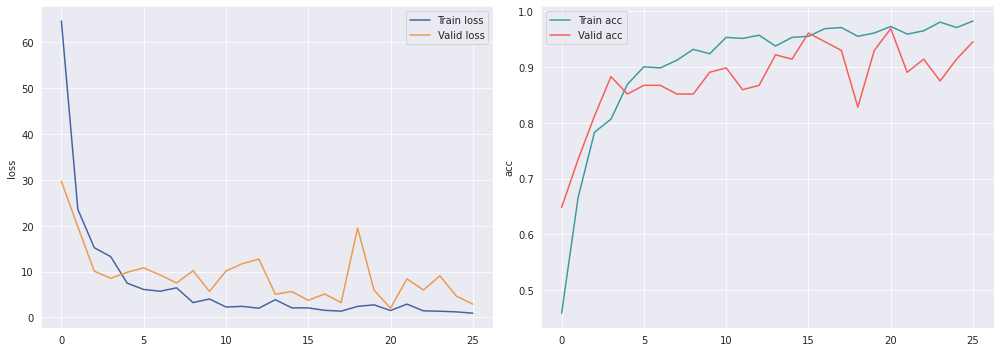

In [11]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(1, 2, figsize=(14,5))
ax[0].plot(LOSS, label="Train loss", color="#4863A0")
ax[0].plot(VAL_LOSS, label="Valid loss", color="#EE9A4D")
ax[0].set_ylabel('loss')
ax[0].legend(loc="upper right")

ax[1].plot(ACC, label="Train acc", color="#3B9C9C")
ax[1].plot(VAL_ACC, label="Valid acc", color="#F75D59")
ax[1].set_ylabel('acc')
ax[1].legend(loc="upper left")

plt.tight_layout()
plt.show()

In [12]:
model = QNN(NUM_CLASS).to(device)
model.load_state_dict(torch.load('saved_model.pth'))
model.eval()  
    
def calculate_acc(outputs, labels, total, correct):
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    return total,correct

with torch.no_grad():
    acc,total = 0,0
    for images, labels in tqdm(test_loader, desc="Test"):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        total, acc = calculate_acc(outputs, labels, total, acc)
    print('Accuracy of 128 test images: {:5.2f} %'.format(100*acc/total))


Accuracy of 128 test images: 93.75 %
